<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/BERTGCNAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Setup and Data Loading



In [1]:
# Install dependencies
!pip install torch torch-geometric transformers imbalanced-learn -q

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy import io as sio

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')

# Extract network features and handle NaN
network_features = df[['share_count', 'reaction_count', 'comment_count']].fillna(0).values  # Replace NaN with 0
print("NaN in network features before filling:", np.isnan(network_features).any())  # Should be True if NaN exists
print("NaN in network features after filling:", np.isnan(network_features).any())  # Should be False

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features)  # (2282, 3)
print("NaN in X_net_std:", np.isnan(X_net_std).any())  # Should be False

# Save standardized features
sio.savemat('network.mat', {'X_net_std': X_net_std})
print("Network features shape:", X_net_std.shape)

# Prepare labels (binary classification)
labels = df['Rating'].apply(lambda x: 0 if x == 'mostly true' else 1).values  # 0: mostly true, 1: others
y = np.array(labels)
print("Label distribution:", np.bincount(y))  # [1669, 613]

# Move files to Google Drive
!mv /content/network.mat /content/drive/MyDrive/Projects/Hayat/
print("Network features saved to Google Drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s eta 0:00:00
Mounted at /content/drive
NaN in network feat

## Bar Chart (Class Distribution):



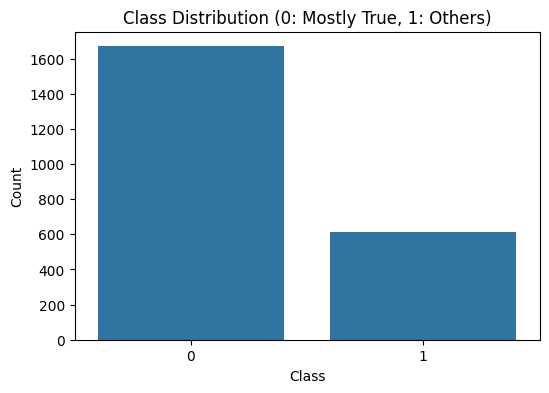

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (0: Mostly True, 1: Others)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Pie Chart (Class Proportions):


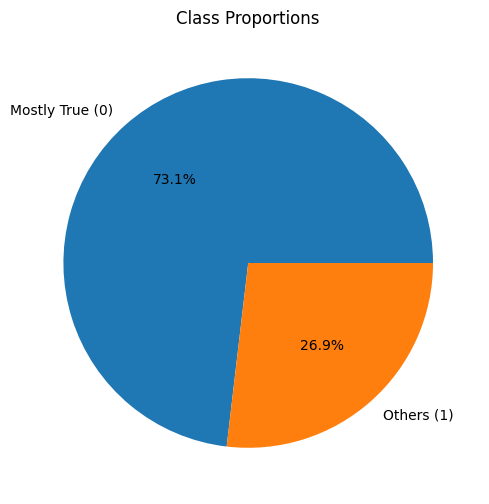

In [3]:
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(y), labels=['Mostly True (0)', 'Others (1)'], autopct='%1.1f%%')
plt.title("Class Proportions")
plt.show()

## Box Plot (Feature Spread):



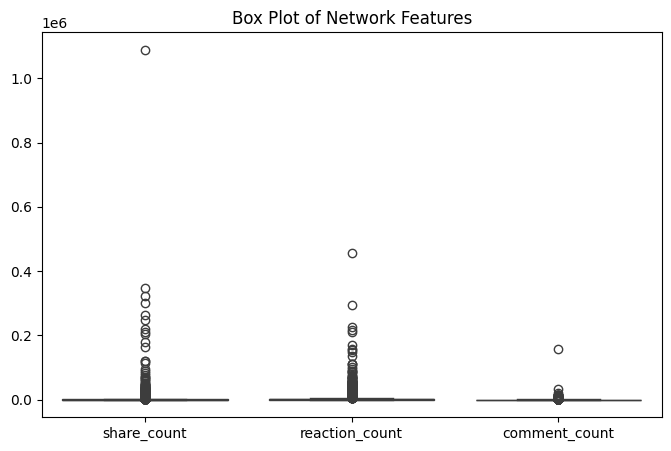

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['share_count', 'reaction_count', 'comment_count']].fillna(0))
plt.title("Box Plot of Network Features")
plt.show()

## Table (Summary Statistics):



In [7]:
print("Summary Statistics of Network Features:")
print(pd.DataFrame(network_features, columns=['share_count', 'reaction_count', 'comment_count']).describe())

Summary Statistics of Network Features:
        share_count  reaction_count  comment_count
count  2.282000e+03     2282.000000    2282.000000
mean   3.920741e+03     5359.583260     515.649869
std    2.937889e+04    19118.816835    3567.822982
min    0.000000e+00        0.000000       0.000000
25%    2.000000e+01      149.000000      36.250000
50%    8.700000e+01      543.000000     131.000000
75%    6.800000e+02     2414.250000     390.000000
max    1.088995e+06   456458.000000  159047.000000


# Step 2: Social Branch (Graph Construction and GCN Embeddings)



In [8]:
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops

# Load standardized network features
X_net_std = sio.loadmat('/content/drive/MyDrive/Projects/Hayat/network.mat')['X_net_std']
print("NaN in X_net_std (loaded):", np.isnan(X_net_std).any())  # Should be False

# Construct graph
G = nx.Graph()
for idx in range(len(df)):
    G.add_node(idx, features=X_net_std[idx])
account_groups = df.groupby('account_id').indices
for account_id, indices in account_groups.items():
    indices = list(indices)
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            G.add_edge(indices[i], indices[j])
print("Graph nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Prepare GNN data
edges = list(G.edges)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index
print("GNN Data:", data)

# Define GCN model
class GCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Compute GCN embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN().to(device)
data = data.to(device)
gcn_model.eval()
with torch.no_grad():
    gcn_embeddings = gcn_model(data)  # (2282, 128)
print("GCN Embeddings shape:", gcn_embeddings.shape)
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())  # Should be False

# Save GCN model and embeddings
torch.save(gcn_model.state_dict(), 'gcn_model.pth')
torch.save(gcn_embeddings.cpu(), 'gcn_embeddings.pt')
print("GCN model and embeddings saved")

# Move to Google Drive
!mv /content/gcn_model.pth /content/drive/MyDrive/Projects/Hayat/
!mv /content/gcn_embeddings.pt /content/drive/MyDrive/Projects/Hayat/
print("GCN model and embeddings moved to Google Drive")

NaN in X_net_std (loaded): False
Graph nodes: 2282 Edges: 368312
GNN Data: Data(x=[2282, 3], edge_index=[2, 370594])
GCN Embeddings shape: torch.Size([2282, 128])
NaN in gcn_embeddings: False
GCN model and embeddings saved
GCN model and embeddings moved to Google Drive


## Histogram (Node Degree Distribution):



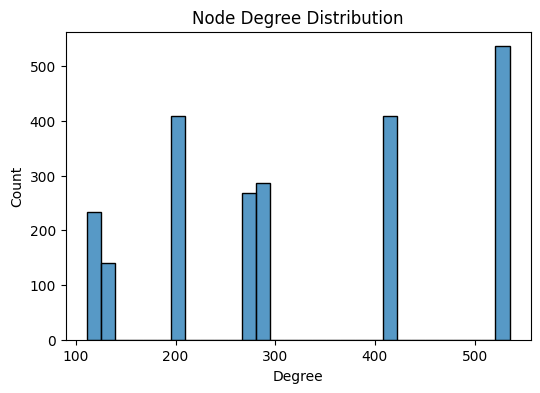

In [9]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(6, 4))
sns.histplot(degrees, bins=30)
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

## Heatmap (Feature Correlation):



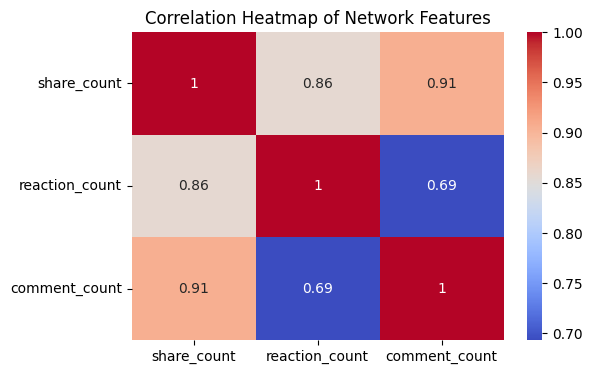

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Network Features")
plt.show()

## Table (Graph Statistics):



In [11]:
print("Graph Statistics:")
print(pd.DataFrame({
    'Nodes': [G.number_of_nodes()],
    'Edges': [G.number_of_edges()],
    'Avg Degree': [np.mean([d for _, d in G.degree()])]
}))

Graph Statistics:
   Nodes   Edges  Avg Degree
0   2282  368312  322.797546


# Step 3: Text Branch (BERT + Attention Embeddings)



In [12]:
from transformers import BertTokenizer, BertModel

# Define Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, embeddings):
        scores = self.attention(embeddings)  # (batch_size, seq_len, 1)
        scores = torch.softmax(scores, dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(embeddings * scores, dim=1)  # (batch_size, hidden_dim)
        return context

# BERT Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()
attention_layer = Attention(hidden_dim=768).to(device)

# Process texts with BERT + Attention
batch_size = 32
bert_embeddings = []
texts = df['Context Post'].fillna("").tolist()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=117)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
        token_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, 768)
        context_vector = attention_layer(token_embeddings)  # (batch_size, 768)
        bert_embeddings.append(context_vector.cpu())

# Concatenate all batches
bert_embeddings = torch.cat(bert_embeddings, dim=0)  # (2282, 768)
print("BERT Embeddings with Attention shape:", bert_embeddings.shape)
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())  # Should be False

# Save embeddings
torch.save(bert_embeddings, 'bert_embeddings_with_attention.pt')
!mv /content/bert_embeddings_with_attention.pt /content/drive/MyDrive/Projects/Hayat/
print("BERT embeddings with Attention saved to Google Drive")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Embeddings with Attention shape: torch.Size([2282, 768])
NaN in bert_embeddings: False
BERT embeddings with Attention saved to Google Drive


## Histogram (Text Length Distribution):



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


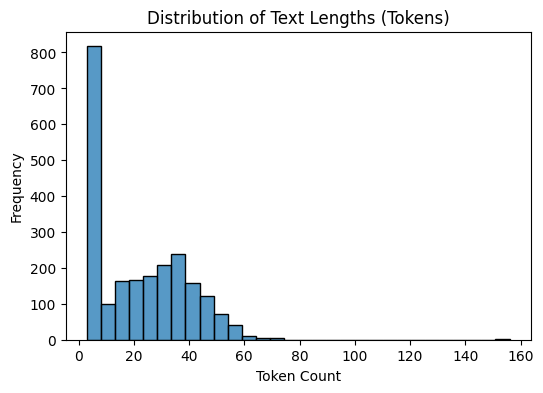

In [13]:
text_lengths = [len(tokenizer.encode(text, max_length=512)) for text in texts]
plt.figure(figsize=(6, 4))
sns.histplot(text_lengths, bins=30)
plt.title("Distribution of Text Lengths (Tokens)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

## Box Plot (Embedding Norms):



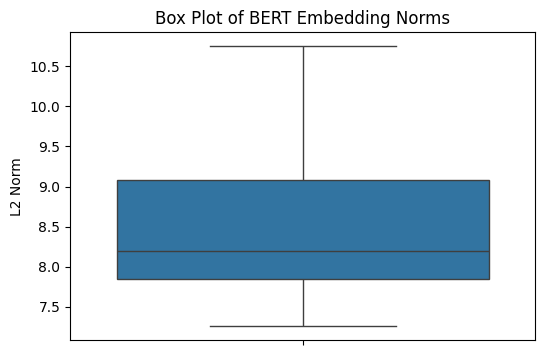

In [14]:
norms = torch.norm(bert_embeddings, dim=1).numpy()
plt.figure(figsize=(6, 4))
sns.boxplot(y=norms)
plt.title("Box Plot of BERT Embedding Norms")
plt.ylabel("L2 Norm")
plt.show()

# Step 4: Combine Embeddings and Address Class Imbalance



In [15]:
from imblearn.over_sampling import SMOTE

# Load embeddings
gcn_embeddings = torch.load('/content/drive/MyDrive/Projects/Hayat/gcn_embeddings.pt')  # (2282, 128)
bert_embeddings = torch.load('/content/drive/MyDrive/Projects/Hayat/bert_embeddings_with_attention.pt')  # (2282, 768)

# Check for NaN in embeddings
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())

# Combine embeddings
combined_embeddings = torch.cat((gcn_embeddings, bert_embeddings), dim=1)  # (2282, 896)
print("Combined embeddings shape:", combined_embeddings.shape)
print("NaN in combined_embeddings:", torch.isnan(combined_embeddings).any().item())

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_embeddings.numpy(), y)
X_resampled = torch.tensor(X_resampled, dtype=torch.float)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
print("Resampled data shape:", X_resampled.shape, "Label distribution:", np.bincount(y_resampled))

NaN in gcn_embeddings: False
NaN in bert_embeddings: False
Combined embeddings shape: torch.Size([2282, 896])
NaN in combined_embeddings: False
Resampled data shape: torch.Size([3338, 896]) Label distribution: [1669 1669]


In [ ]:
# Check for NaN in embeddings
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())
print("NaN in combined_embeddings:", torch.isnan(combined_embeddings).any().item())

NaN in gcn_embeddings: True
NaN in bert_embeddings: False
NaN in combined_embeddings: True


# Step 5: Ensemble and Train the Classifier



In [ ]:
# Define the ensemble classifier
class EnsembleClassifier(nn.Module):
    def __init__(self, input_dim=896, hidden_dim1=512, hidden_dim2=256, num_classes=2):
        super(EnsembleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Prepare data for training
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)
print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize model, loss, and optimizer
ensemble_classifier = EnsembleClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_classifier.parameters(), lr=0.0005)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 50

for epoch in range(num_epochs):
    # Training
    ensemble_classifier.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = ensemble_classifier(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    ensemble_classifier.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = ensemble_classifier(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(ensemble_classifier.state_dict(), 'best_ensemble_classifier.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Evaluate on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

ensemble_classifier.load_state_dict(torch.load('best_ensemble_classifier.pth'))
ensemble_classifier.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = ensemble_classifier(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
print("\nEnsemble Test Results:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("\nEnsemble Classification Report:")
print(classification_report(y_true, y_pred, target_names=['mostly true (0)', 'others (1)']))

# Save the model
torch.save(ensemble_classifier.state_dict(), 'final_ensemble_classifier.pth')
!mv /content/final_ensemble_classifier.pth /content/drive/MyDrive/Projects/Hayat/
!mv /content/best_ensemble_classifier.pth /content/drive/MyDrive/Projects/Hayat/
print("Ensemble model saved to Google Drive")

Train size: 1868 Val size: 468 Test size: 1002
Epoch 1/50, Train Loss: 0.5520, Val Loss: 0.5015
Epoch 2/50, Train Loss: 0.4721, Val Loss: 0.4955
Epoch 3/50, Train Loss: 0.4552, Val Loss: 0.4766
Epoch 4/50, Train Loss: 0.4378, Val Loss: 0.4724
Epoch 5/50, Train Loss: 0.4100, Val Loss: 0.4581
Epoch 6/50, Train Loss: 0.4064, Val Loss: 0.4591
Epoch 7/50, Train Loss: 0.3995, Val Loss: 0.4405
Epoch 8/50, Train Loss: 0.3827, Val Loss: 0.4418
Epoch 9/50, Train Loss: 0.3822, Val Loss: 0.4366
Epoch 10/50, Train Loss: 0.3603, Val Loss: 0.4386
Epoch 11/50, Train Loss: 0.3381, Val Loss: 0.4332
Epoch 12/50, Train Loss: 0.3329, Val Loss: 0.4451
Epoch 13/50, Train Loss: 0.3297, Val Loss: 0.4490
Epoch 14/50, Train Loss: 0.3116, Val Loss: 0.4380
Epoch 15/50, Train Loss: 0.2937, Val Loss: 0.4527
Epoch 16/50, Train Loss: 0.2792, Val Loss: 0.4333
Epoch 17/50, Train Loss: 0.2845, Val Loss: 0.4571
Epoch 18/50, Train Loss: 0.2826, Val Loss: 0.4541
Epoch 19/50, Train Loss: 0.2784, Val Loss: 0.4571
Epoch 20/50,

# Step 6: Deployment



In [ ]:
# Load models for inference
gcn_model = GCN().to(device)
gcn_model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/gcn_model.pth', map_location=device))
gcn_model.eval()

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

attention_layer = Attention(hidden_dim=768).to(device)

ensemble_classifier = EnsembleClassifier().to(device)
ensemble_classifier.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/final_ensemble_classifier.pth', map_location=device))
ensemble_classifier.eval()

# Load scaler
scaler = StandardScaler()
scaler.fit(sio.loadmat('/content/drive/MyDrive/Projects/Hayat/network.mat')['X_net_std'])

# Inference function
def predict_veracity(post_data):
    """
    post_data: dict with 'account_id', 'share_count', 'reaction_count', 'comment_count', 'Context Post'
    Returns: dict with predicted class and probabilities
    """
    # Social branch: GCN
    network_features = np.array([[post_data['share_count'],
                                  post_data['reaction_count'],
                                  post_data['comment_count']]])
    X_net_std = scaler.transform(network_features)  # (1, 3)
    x = torch.tensor(X_net_std, dtype=torch.float).to(device)
    edge_index = torch.tensor([[0], [0]], dtype=torch.long).to(device)  # Self-loop
    data = Data(x=x, edge_index=edge_index).to(device)
    with torch.no_grad():
        gcn_emb = gcn_model(data)  # (1, 128)

    # Text branch: BERT + Attention
    text = post_data['Context Post'] or ""
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=117)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        bert_out = bert_model(**inputs)
        token_embeddings = bert_out.last_hidden_state  # (1, seq_len, 768)
        bert_emb = attention_layer(token_embeddings)  # (1, 768)

    # Combine embeddings
    combined_emb = torch.cat((gcn_emb, bert_emb), dim=1)  # (1, 896)

    # Predict with ensemble classifier
    with torch.no_grad():
        logits = ensemble_classifier(combined_emb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # [P(0), P(1)]
        pred = np.argmax(probs)

    return {
        'prediction': 'mostly true' if pred == 0 else 'others',
        'probabilities': {'mostly true': probs[0], 'others': probs[1]}
    }

# Example usage
new_post = {
    'account_id': '123',
    'share_count': 10,
    'reaction_count': 50,
    'comment_count': 20,
    'Context Post': 'This is a sample post about a news event.'
}
result = predict_veracity(new_post)
print("Prediction:", result['prediction'])
print("Probabilities:", result['probabilities'])

Prediction: others
Probabilities: {'mostly true': np.float32(0.34932137), 'others': np.float32(0.6506787)}
